<center><h1>Panchal_Apoorva_HW7</h1></center>

Name: Apoorva Panchal
<br>
Github Username: ApoorvaPanchal
<br>
USC ID: 8685016290

Note : Used 2 late days

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [1]:
import zipfile
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from urllib.request import urlretrieve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tabulate import tabulate

### (a) Download the Anuran Calls (MFCCs) Data Set

In [2]:
# url = 'https://archive.ics.uci.edu/static/public/406/anuran+calls+mfccs.zip'
# filename = '../data/anuran_calls.zip'
# urlretrieve(url, filename)
# zip = zipfile.ZipFile('../data/anuran_calls.zip', 'r').extractall('../data/')

In [3]:
data = pd.read_csv('../data/Frogs_MFCCs.csv')
data.drop(columns=['RecordID'], inplace=True)
y_labels = ['Family', 'Genus', 'Species']

### (b) Train a classifier for each label

#### (i) Research

Evaluation of Multi-label Classification:   
*   Exact Match: Accuracy score which calculates subset accuracy where the predicted set of labels should exactly match with the true set of labels. Not accurate because if one of the labels out of all is wrong, the entire prediction is considered incorrect.   
   
*   Hamming Loss: Fraction of wrong labels out of the total number of labels.   

In [4]:
train_df, test_df = train_test_split(data, test_size=0.3, random_state=42)
X_train = train_df.drop(columns=y_labels)
y_train = train_df[y_labels]
X_test = test_df.drop(columns=y_labels)
y_test = test_df[y_labels]

#### (ii) Train a SVM for each of the labels

In [5]:
models = []
y_preds = {}
for label in y_labels:
    params = {'estimator__C': [10**i for i in range(-1, 4)],
            'estimator__gamma': np.arange(0.1, 3, 0.1)}
    svm_ovr = OneVsRestClassifier(svm.SVC(kernel='rbf', random_state=42))
    svm_ovr_grid = GridSearchCV(svm_ovr, params, cv=10, n_jobs=-1)
    svm_ovr_grid.fit(X_train, y_train[label])
    models.append(svm_ovr_grid)
    y_pred = svm_ovr_grid.predict(X_test)
    
    y_preds[label] = y_pred

In [6]:
model_params = [
    [y_labels[0], models[0].best_params_['estimator__C'], models[0].best_params_['estimator__gamma']],
    [y_labels[1], models[1].best_params_['estimator__C'], models[1].best_params_['estimator__gamma'] ],
    [y_labels[2], models[2].best_params_['estimator__C'], models[2].best_params_['estimator__gamma']]
]
print(tabulate(model_params, headers=['Label/Metrics', 'SVM penalty weight', 'Margin width'], tablefmt='simple_outline'))

y_preds = pd.DataFrame(y_preds)
exact_match_ovr = 0
for i in range(len(y_test)):
    if np.array_equal(y_test.iloc[i], y_preds.iloc[i]):
        exact_match_ovr += 1
    
exact_match_ovr = exact_match_ovr/len(y_test)
print(f'Exact match: {exact_match_ovr}')

hamming_count_ovr = 0
for i in range(len(y_test)):
    for j in range(len(y_test.columns)):
        if y_test.iloc[i, j] != y_preds.iloc[i, j]:
            hamming_count_ovr += 1
hamming_score_ovr = hamming_count_ovr/(len(y_test)*len(y_test.columns))

print(f'Hamming loss: {hamming_score_ovr}')

┌─────────────────┬──────────────────────┬────────────────┐
│ Label/Metrics   │   SVM penalty weight │   Margin width │
├─────────────────┼──────────────────────┼────────────────┤
│ Family          │                   10 │            2.8 │
│ Genus           │                   10 │            2.4 │
│ Species         │                   10 │            2.6 │
└─────────────────┴──────────────────────┴────────────────┘
Exact match: 0.9898100972672533
Hamming loss: 0.007410838351088467


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [7]:
y_preds_lin = {}
models_lin = []
for label in y_labels:
    params = {'estimator__C': [10**i for i in range(-2, 4)]}
    
    svm_lin = svm.LinearSVC(penalty='l1', dual=False, random_state=42, loss='squared_hinge', max_iter=100000)
    pipeline_svm_lin = Pipeline([('scaler', StandardScaler()), ('estimator', svm_lin)])
    svm_lin = GridSearchCV(pipeline_svm_lin, params, cv=10, n_jobs=-1)
    svm_lin.fit(X_train, y_train[label])
    models_lin.append(svm_lin)
    y_pred = svm_lin.predict(X_test)
    
    y_preds_lin[label] = y_pred


In [8]:
model_params_lin = [
    [y_labels[0], models_lin[0].best_params_['estimator__C']],
    [y_labels[1], models_lin[1].best_params_['estimator__C']],
    [y_labels[2], models_lin[2].best_params_['estimator__C']]
]
print(tabulate(model_params_lin, headers=['Label/Metrics', 'SVM penalty weight'], tablefmt='simple_outline'))

y_preds_lin = pd.DataFrame(y_preds_lin)
exact_match_lin = 0
for i in range(len(y_test)):
    if np.array_equal(y_test.iloc[i], y_preds_lin.iloc[i]):
        exact_match_lin += 1
    
exact_match_lin = exact_match_lin/len(y_test)
print(f'Exact match for Linear SVC: {exact_match_lin}')

hamming_count_lin = 0
for i in range(len(y_test)):
    for j in range(len(y_test.columns)):
        if y_test.iloc[i, j] != y_preds_lin.iloc[i, j]:
            hamming_count_lin += 1
hamming_score_lin = hamming_count_lin/(len(y_test)*len(y_test.columns))

print(f'Hamming loss for Linear SVC: {hamming_score_lin}')

┌─────────────────┬──────────────────────┐
│ Label/Metrics   │   SVM penalty weight │
├─────────────────┼──────────────────────┤
│ Family          │                    1 │
│ Genus           │                   10 │
│ Species         │                   10 │
└─────────────────┴──────────────────────┘
Exact match for Linear SVC: 0.9129226493747105
Hamming loss for Linear SVC: 0.05681642735834491


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [9]:
y_preds_smote = {}
models_smote = []
for label in y_labels:
    params = {'estimator__C': [10**i for i in range(-4, 4)]}
    
    svm_lin_smote = svm.LinearSVC(penalty='l1', dual=False, random_state=42, loss='squared_hinge', max_iter=10000)
    pipeline_svm_lin_smote = imbpipeline([('smote', SMOTE()), ('scaler', StandardScaler()), ('estimator', svm_lin_smote)])
    svm_lin_smote = GridSearchCV(pipeline_svm_lin_smote, params, cv=10, n_jobs=-1)
    svm_lin_smote.fit(X_train, y_train[label])
    models_smote.append(svm_lin_smote)
    y_pred = svm_lin_smote.predict(X_test)
    
    y_preds_smote[label] = y_pred

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [10]:
model_params_smote = [
    [y_labels[0], models_smote[0].best_params_['estimator__C']],
    [y_labels[1], models_smote[1].best_params_['estimator__C']],
    [y_labels[2], models_smote[2].best_params_['estimator__C']]
]
print(tabulate(model_params_smote, headers=['Label/Metrics', 'SVM penalty weight'], tablefmt='simple_outline'))

y_preds_smote = pd.DataFrame(y_preds_smote)
exact_match_smote = 0
for i in range(len(y_test)):
    if np.array_equal(y_test.iloc[i], y_preds_smote.iloc[i]):
        exact_match_smote += 1
    
exact_match_smote = exact_match_smote/len(y_test)
print(f'Exact match for Linear SVC with SMOTE: {exact_match_smote}')

hamming_count_smote = 0
for i in range(len(y_test)):
    for j in range(len(y_test.columns)):
        if y_test.iloc[i, j] != y_preds_smote.iloc[i, j]:
            hamming_count_smote += 1

hamming_score_smote = hamming_count_smote/(len(y_test)*len(y_test.columns))
print(f'Hamming loss for Linear SVC with SMOTE: {hamming_score_smote}')

┌─────────────────┬──────────────────────┐
│ Label/Metrics   │   SVM penalty weight │
├─────────────────┼──────────────────────┤
│ Family          │                   10 │
│ Genus           │                  100 │
│ Species         │                    1 │
└─────────────────┴──────────────────────┘
Exact match for Linear SVC with SMOTE: 0.8596572487262621
Hamming loss for Linear SVC with SMOTE: 0.07441716844218002


In [11]:
svc_metrics = [
    ['Gaussian SVM', exact_match_ovr, hamming_score_ovr],
    ['Linear SVM', exact_match_lin, hamming_score_lin],
    ['Linear SVM with SMOTE', exact_match_smote, hamming_score_smote]
]
print(tabulate(svc_metrics, headers=['Model/Metrics', 'Exact Match', 'Hamming Loss'], tablefmt='simple_outline'))

┌───────────────────────┬───────────────┬────────────────┐
│ Model/Metrics         │   Exact Match │   Hamming Loss │
├───────────────────────┼───────────────┼────────────────┤
│ Gaussian SVM          │      0.98981  │     0.00741084 │
│ Linear SVM            │      0.912923 │     0.0568164  │
│ Linear SVM with SMOTE │      0.859657 │     0.0744172  │
└───────────────────────┴───────────────┴────────────────┘


Observations :   
*   As observed from the above table, we can see that the Gaussian model performs the best out of all the other models   
*   Linear SVM with SMOTE performs worse than earlier, hence resampling in not beneficial in this case   
   

Conclusions:  
*   From the above observations we can conclude that the data is not linearly separable, but separable in a higher dimension, which leads to the gaussian kernel performing better than the other two models   

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

In [12]:
X_df = data.drop(columns=y_labels)
y_df = data[y_labels]

In [13]:
iter = 50
max_clusters = 50

hamming_losses = []
hamming_distances = []
optimal_k = []

for i in range(iter):
    print(f'Iteration: {i+1}')
    best_k = 2
    max_score = 0
    for k in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=k, n_init=5)
        labels = kmeans.fit_predict(X_df)
        score = silhouette_score(X_df, labels)
        if score > max_score:
            max_score = score
            best_k = k
    optimal_k.append(best_k)

    print(f'Best k: {best_k}')
    kmeans = KMeans(n_clusters=best_k, n_init=5)
    labels = kmeans.fit_predict(X_df)
    majority = pd.DataFrame(columns=y_labels)
    for j in range(best_k):
        cluster = data.iloc[labels == j]
        for label in y_labels:
            majority.loc[j, label] = cluster[label].value_counts().idxmax()
    print(majority)

    misclass_count = 0
    for j in range(len(majority)):
        cluster = data.iloc[labels == j]
        for label in y_labels:
            misclass_count += len(cluster[label][cluster[label] != majority.loc[j, label]])
    
    hamming_dist = misclass_count/y_df.shape[0]
    hamming_loss = misclass_count/(y_df.shape[0]*y_df.shape[1])
    print(f'Hamming distance: {hamming_dist}')
    print(f'Hamming loss: {hamming_loss}')
    print(f'Hamming score: {1-hamming_loss}')
    print('-------------------------------\n')

    hamming_losses.append(hamming_loss)
    hamming_distances.append(hamming_dist)



Iteration: 1


Best k: 4
            Family      Genus                 Species
0  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
1    Dendrobatidae   Ameerega      Ameeregatrivittata
2          Hylidae  Hypsiboas       HypsiboasCordobae
3          Hylidae  Hypsiboas    HypsiboasCinerascens
Hamming distance: 0.6472550382209868
Hamming loss: 0.2157516794069956
Hamming score: 0.7842483205930044
-------------------------------

Iteration: 2
Best k: 4
            Family      Genus                 Species
0          Hylidae  Hypsiboas    HypsiboasCinerascens
1          Hylidae  Hypsiboas       HypsiboasCordobae
2  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
3    Dendrobatidae   Ameerega      Ameeregatrivittata
Hamming distance: 0.6661570535093815
Hamming loss: 0.22205235116979383
Hamming score: 0.7779476488302062
-------------------------------

Iteration: 3
Best k: 4
            Family      Genus                 Species
0  Leptodactylidae  Adenomera  AdenomeraHylaedactylus
1          Hylidae  H

### (b) Determine which family is the majority

Done in the above code

### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [14]:
print(f'Average Hamming loss: {np.mean(hamming_losses)}')
print(f'Average Hamming distance: {np.mean(hamming_distances)}')
print(f'Standard Deviation for Hamming distance: {1-np.std(hamming_losses)}')
print(f'Average Hamming Score: {1-np.mean(hamming_losses)}')
print(f'Average Best K : {np.mean(optimal_k)}')


Average Hamming loss: 0.2257197127634932
Average Hamming distance: 0.6771591382904794
Standard Deviation for Hamming distance: 0.9923829383019526
Average Hamming Score: 0.7742802872365068
Average Best K : 4.0


## 3. ISLR 12.6.2

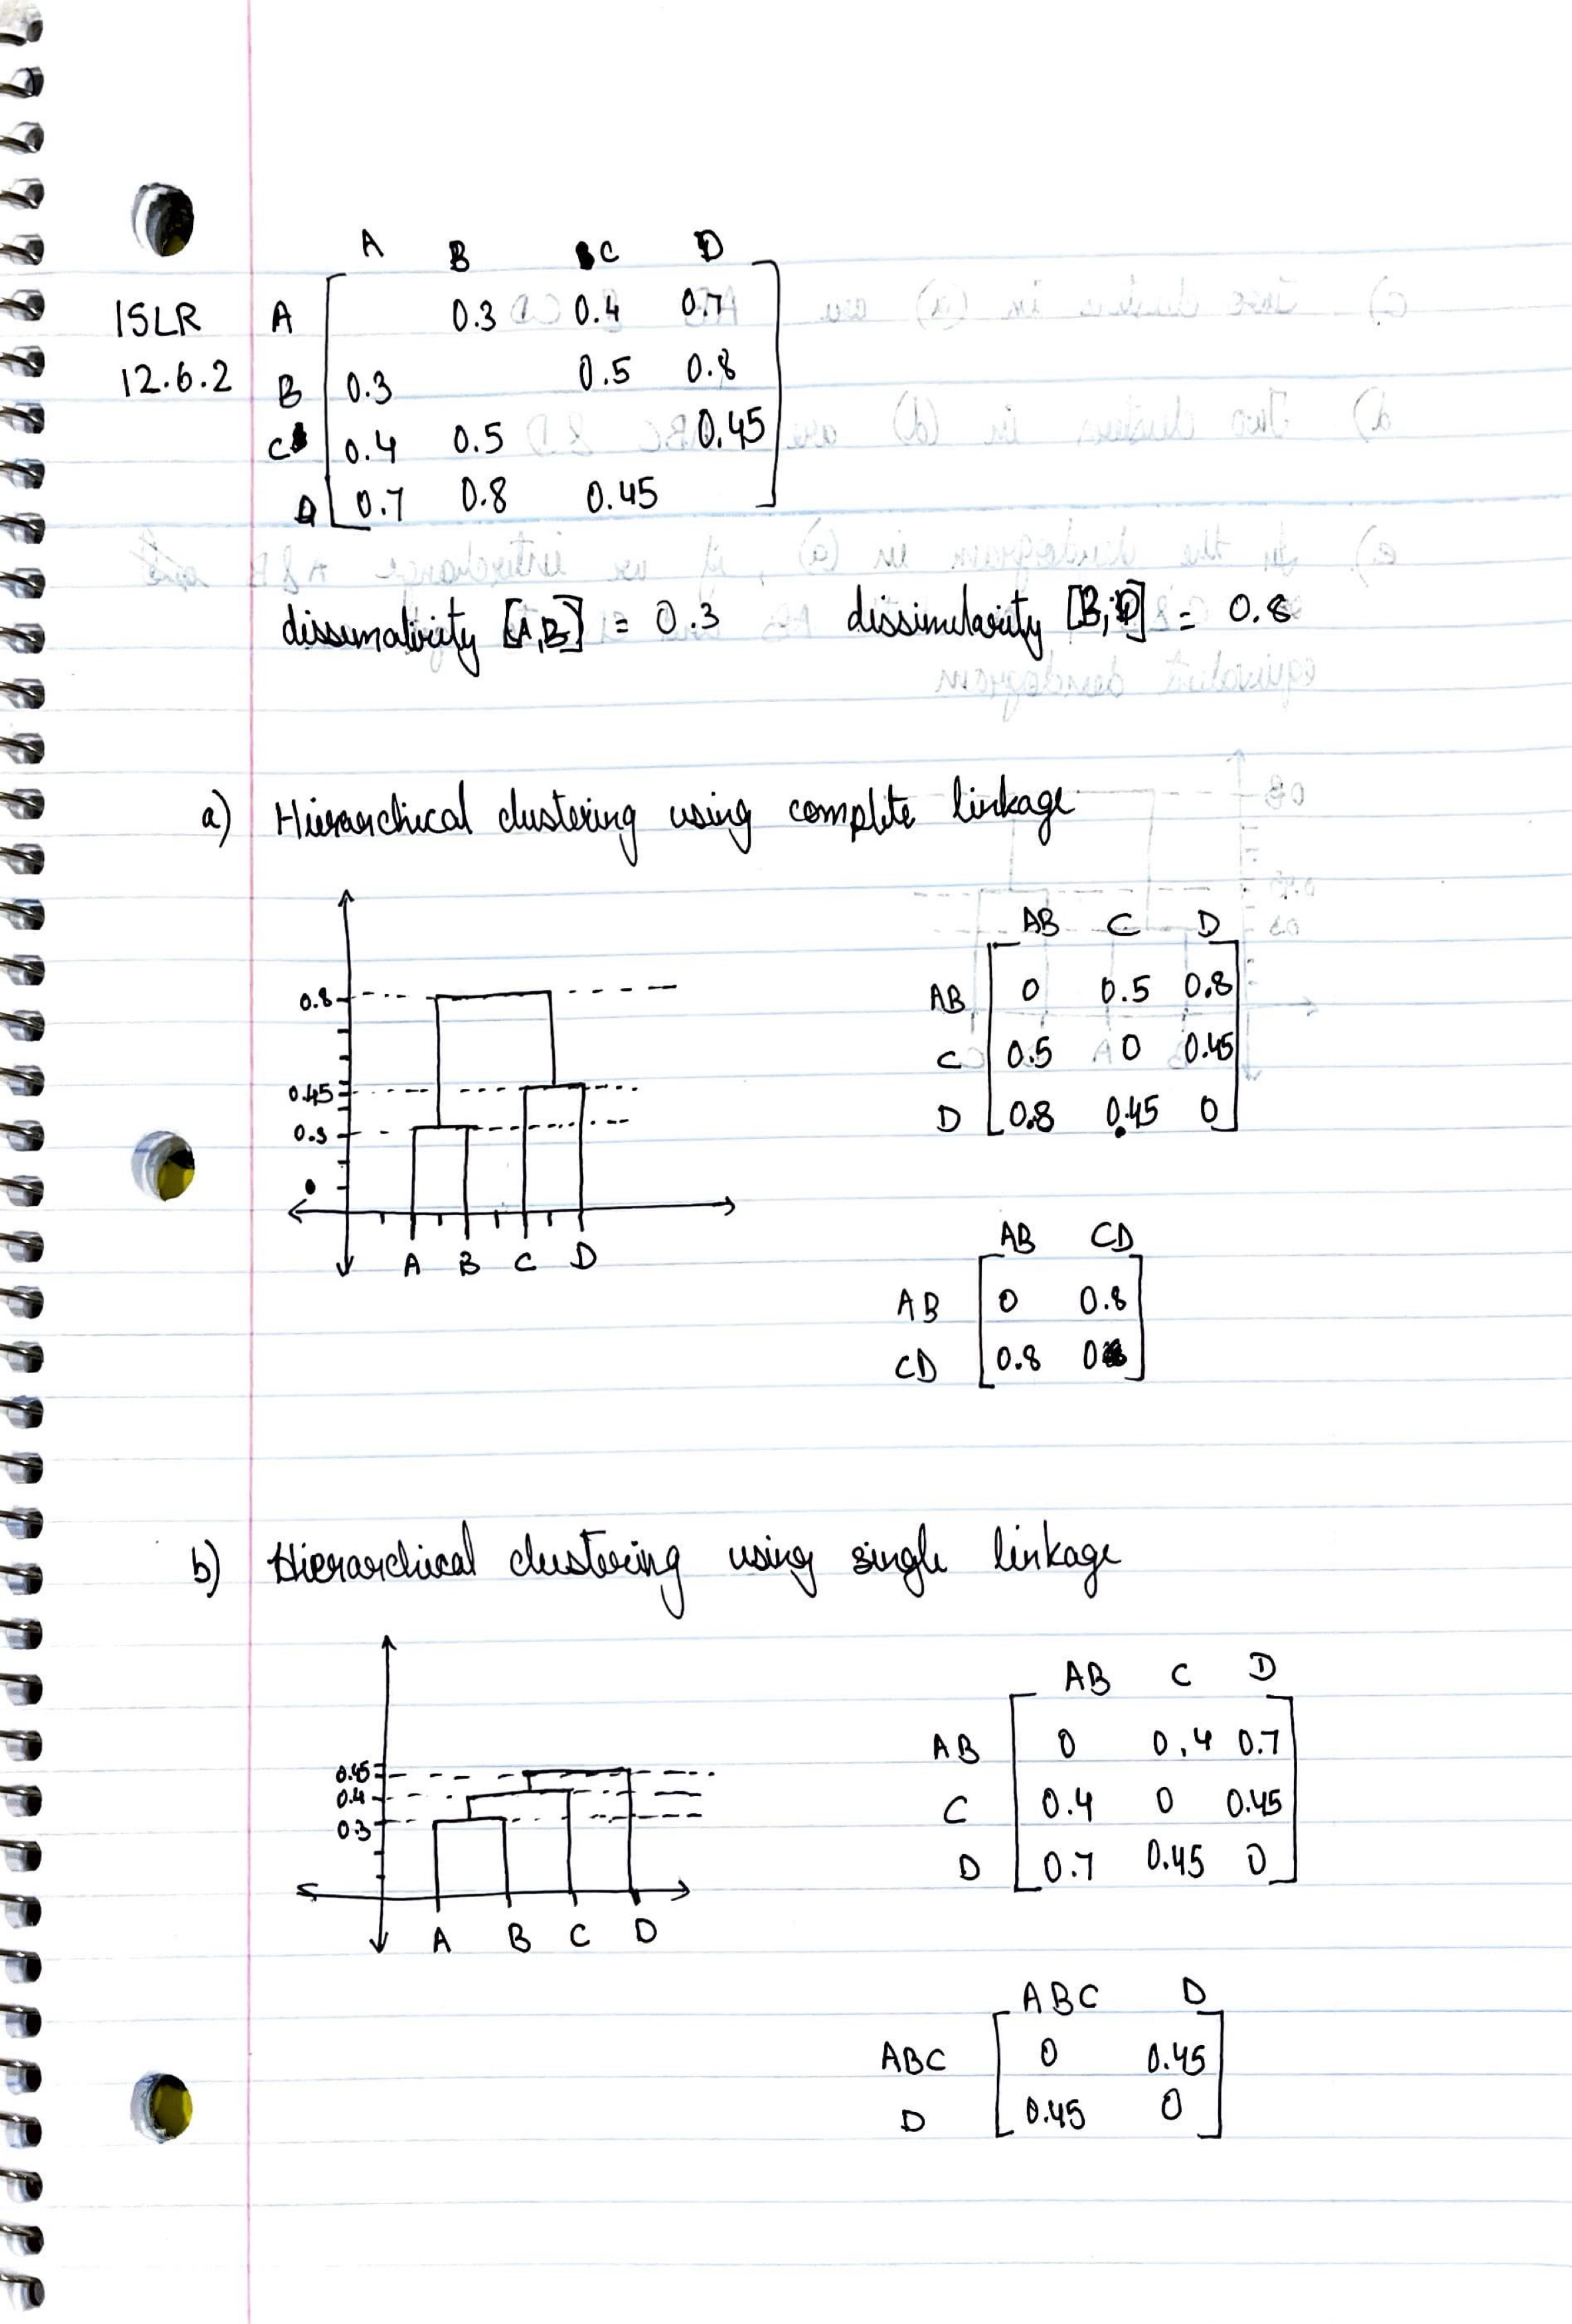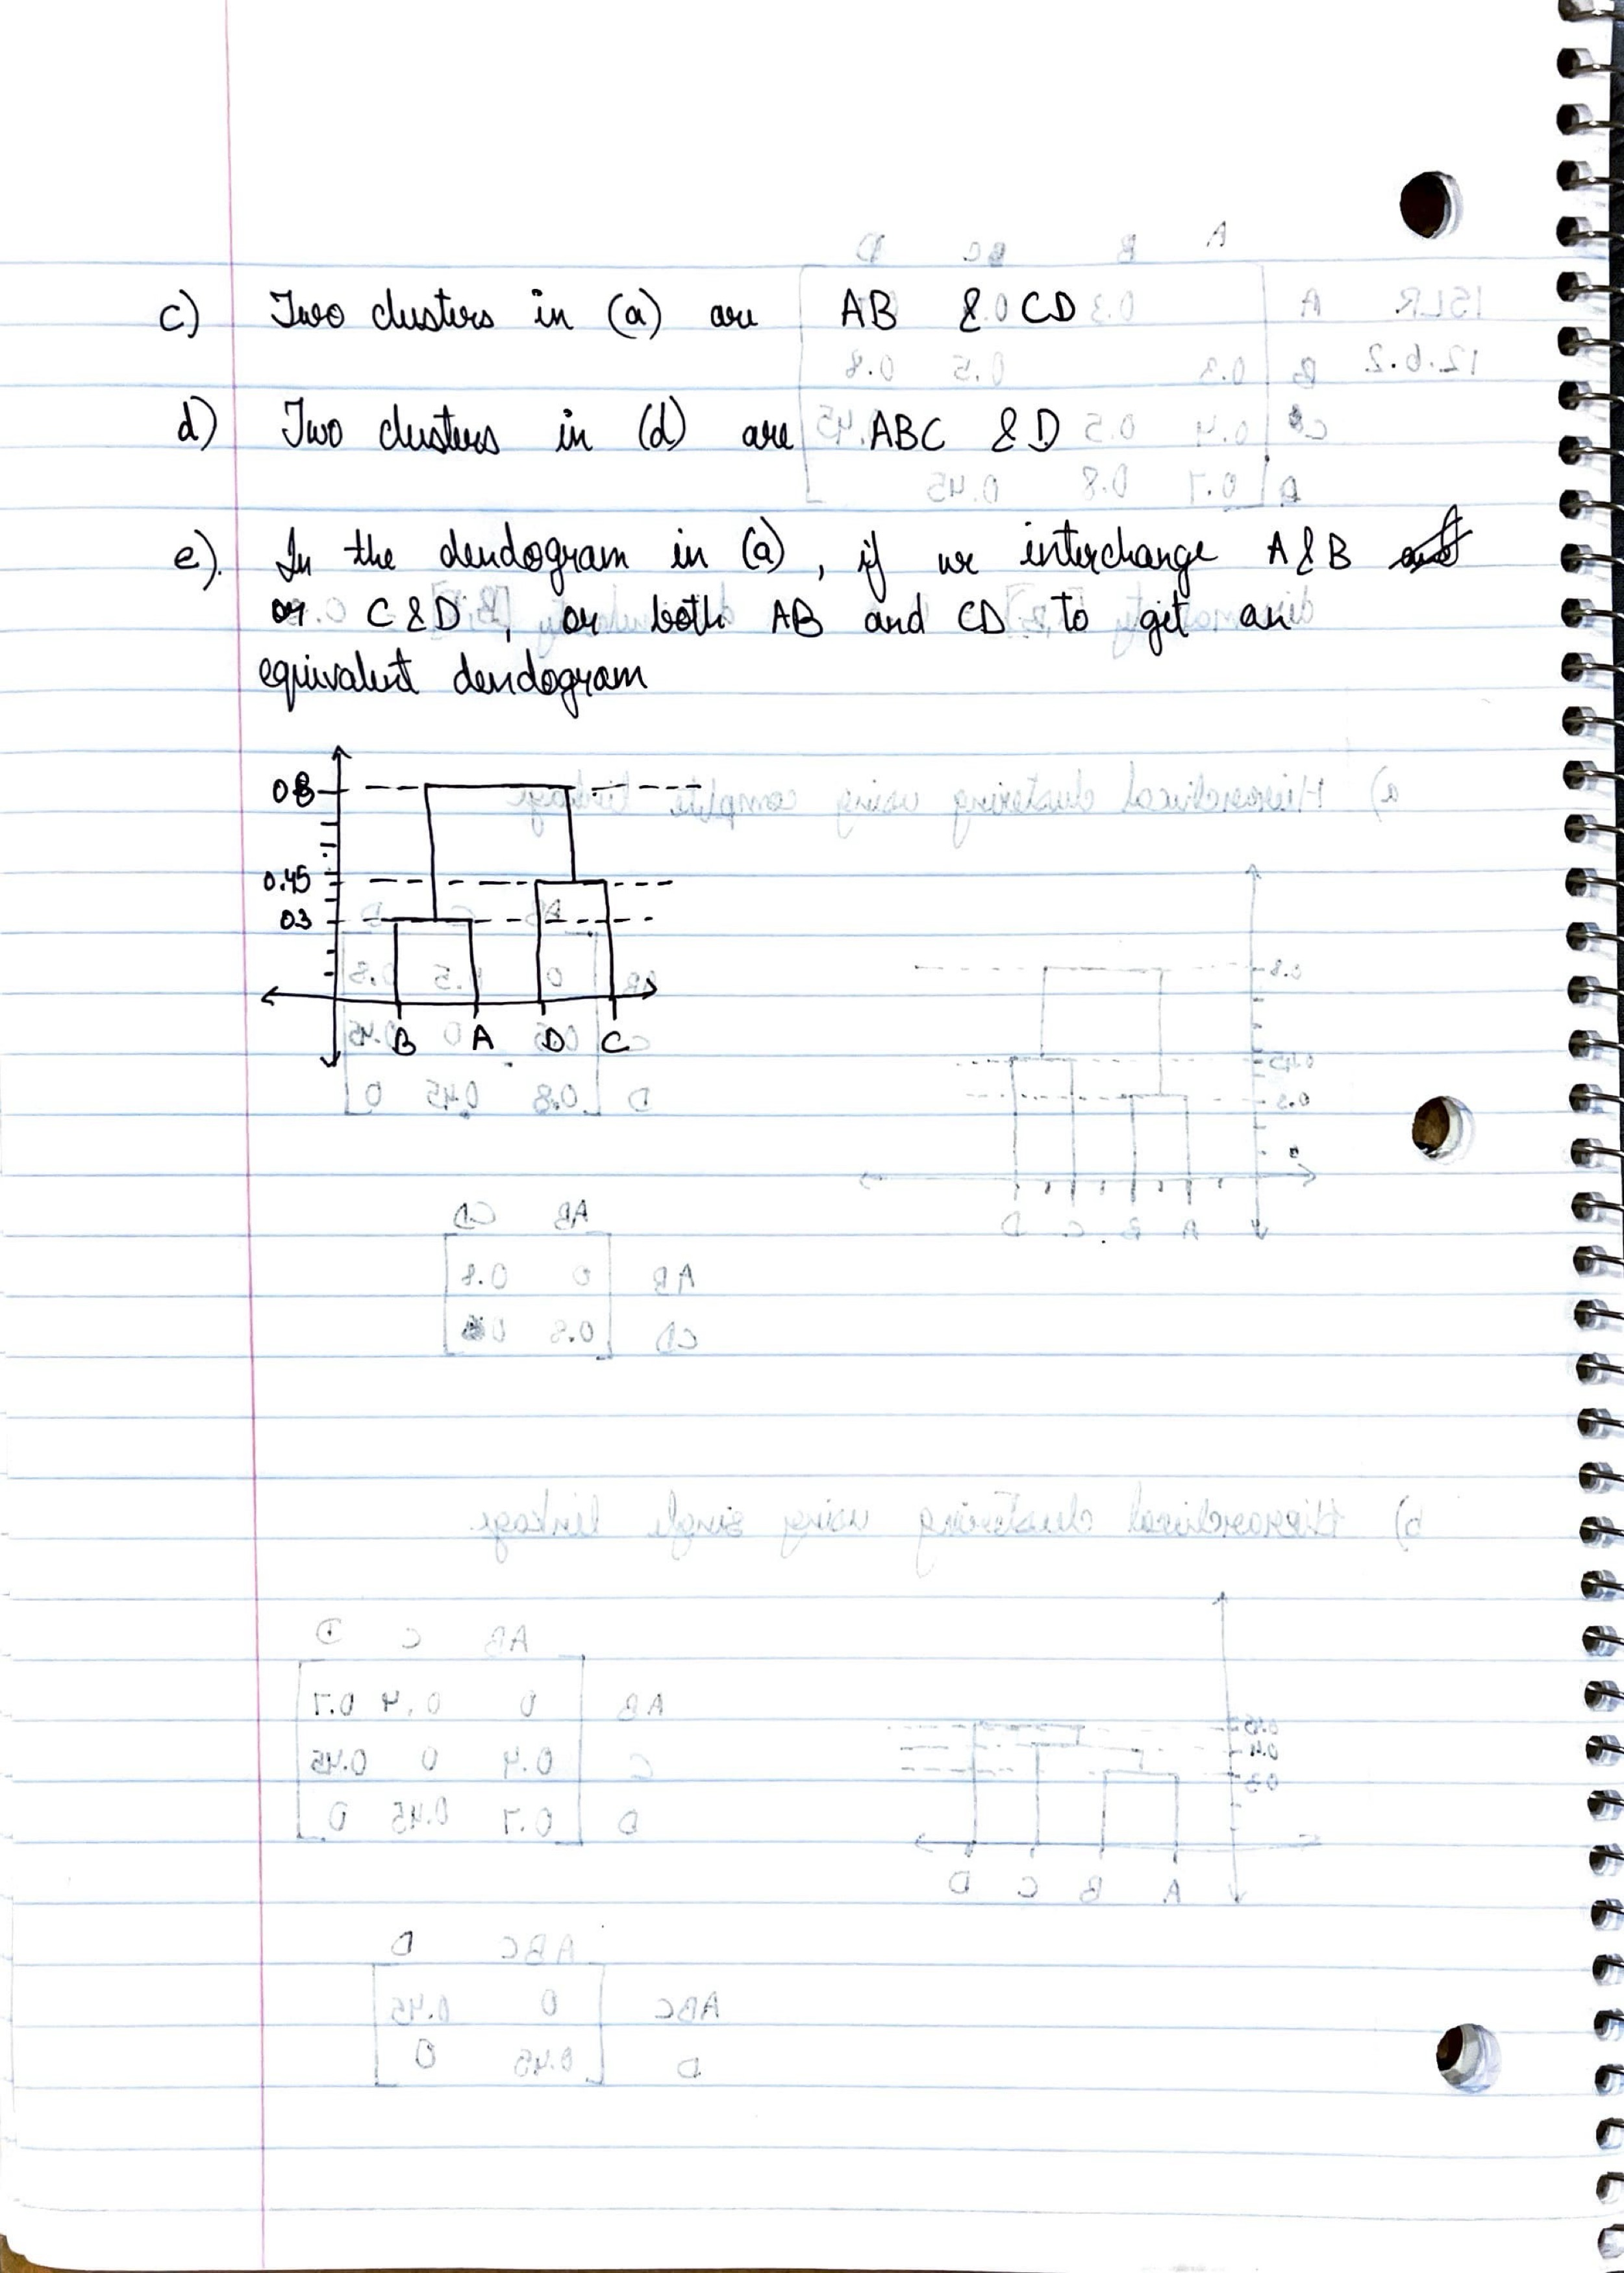